# COVID screening lab simulation

This version of the simulation is based on the following process description, with the option to adjust the batch size of the hat stage, e.g. 93 or 372 tubes as on one process step).

<img src="figs/process_2.png">

## Requirements and module imports

Code in this simulation uses a standard Anaconda Python environment (https://www.anaconda.com/distribution/#download-section). Additionally this model uses SimPy3 (https://simpy.readthedocs.io/en/latest/). Install SimPy3 with `pip install 'simpy<4'`.

In [1]:
import simpy
import inspect
from sim_utils.replication import Replicator
from sim_utils.parameters import Scenario

## Set up scenarios

Parameters defined in scenarios will overwrite default values in the parameters python file.

In [2]:
# Set up a dictionary to hold scenarios
scenarios = {}

scenarios['30k_example'] = Scenario(

    samples_per_day=30132,

    # Basic unit of operation
    basic_batch_size=93,

    # Batch sizing for heat stage (multiples of basic_batch_size)
    heat_batch_size=4,

    # Equipment and workstation cpapacity gives 34k without FTE constraints
    resource_numbers={
        'human_sample_receipt_1': 35,
        'human_sample_receipt_2': 10,
        'human_sample_prep_1': 35,
        'human_sample_prep_2': 22,
        'human_pcr_1': 35,
        'human_pcr_2': 25,
        'sample_heat_incubator': 10,
        'pcr_plate_stamper': 9,
        'pcr_plate_reader': 15,
        'sample_prep_automation': 5
    },

    # Workstation capapcity was set to give 37.5k per workstation, 35 overall
    workstation_capacity={
        'workstation_0': 9999,
        'workstation_1a': 21,
        'workstation_1b_man': 25,
        'workstation_1b_auto': 5,
        'workstation_1c': 10,
        'workstation_2': 0,
        'workstation_3': 9,
        'workstation_4': 15
    },

    # Resource available hours (use hours)
    resource_shift_hours={
        'human_sample_receipt_1': (0.30, 9.00),
        'human_sample_receipt_2': (9.01, 17.75),
        'human_sample_prep_1': (0.30, 9.00),
        'human_sample_prep_2': (9.01, 17.75),
        'human_pcr_1': (0.30, 9.00),
        'human_pcr_2': (9.01, 17.75),
        'sample_heat_incubator': (0.0, 24.0),
        'pcr_plate_stamper': (0.0, 24.0),
        'pcr_plate_reader': (0.0, 24.0),
        'sample_prep_automation': (0.0, 24.0)
    },

    # FTE should always be present for start times
    process_start_hours={
        'sample_receipt': (0.3, 17.2),
        'sample_prep': (0.3, 16.9),
        'sample_heat': (0.3, 17.3),
        'pcr_prep': (0.3, 16.8),
        'pcr': (0.3, 24)
    },

    # Process duration. Tuple of fixed time, time per entity, and time per item
    # in entity. Multi-step automated processes have three sets of times
    # (set up, automated, clean down)
    process_duration={
        'batch_input': ([0, 0, 0],),
        'sample_receipt': ([33, 0, 0],),
        'sample_prep_manual': ([51, 0, 0],),
        'sample_prep_auto': ([25, 0, 0], [6, 0, 0], [6, 0, 0]),
        'sample_heat': ([2, 0, 0], [30, 0, 0], [2, 0, 0]),
        'pcr_prep': ([45, 0, 0], [5, 0, 0], [4, 0, 0]),
        'pcr': ([5, 0, 0], [90, 0, 0], [5, 0, 0]),
        'data_analysis': ([0, 0, 0],)
    },

    # Resource unavailability on any whole day due to breakdown
    resource_breakdown_unavailability={
        'human_sample_receipt_1': 0,
        'human_sample_receipt_2': 0,
        'human_sample_prep_1': 0,
        'human_sample_prep_2': 0,
        'human_pcr_1': 0,
        'human_pcr_2': 0,
        'sample_heat_incubator': 0,
        'pcr_plate_stamper': 0.08,
        'pcr_plate_reader': 0.02,
        'sample_prep_automation': 0,
    },

    allow_maual_sample_prep=True,
    tea_break_times=[2 * 60, 7 * 60, 12 * 60, 16 * 60],
    meal_break_times=[4 * 60, 14 * 60],
    break_start_spread=60,
    tea_break_duration=[25, 35],
    meal_break_duration=[40, 50]
)

## Run model

                                                                               
Output results
--------------
                                            min          mean    median  \
                                         Result        Result    Result   
result_type               name                                            
demand_met                30k_example      0.90      0.956667      0.95   
input                     30k_example  30132.00  30132.000000  30132.00   
max_process_time_hours    30k_example     16.95     17.594667     17.75   
median_process_time_hours 30k_example     16.95     17.594667     17.75   
output                    30k_example  27156.00  28805.200000  28644.00   

                                            max  
                                         Result  
result_type               name                   
demand_met                30k_example      1.00  
input                     30k_example  30132.00  
max_process_time_hours    30k_example  

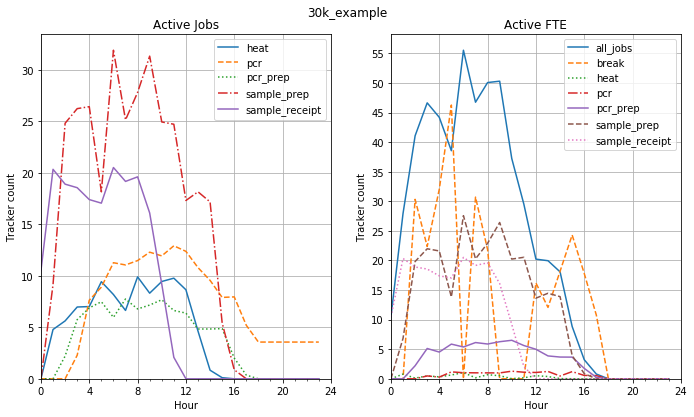

In [3]:
replications = 30
replications = Replicator(scenarios, replications)
replications.run_scenarios()

## Show model default parameters

Run the code below to model defaults these are over-ridden by scenarios).

In [4]:
print(inspect.getsource(Scenario.__init__))

    def __init__(self, *initial_data, **kwargs):
        
        # Set default values
        # 16/4/2020 Adjust paramters so that day starts with FTE arrival


        # Work arrival
        self.samples_per_day = 30132
        self.deliveries_per_day = 1
        self.basic_batch_size = 93

        # Day and run parameters
        # 16/4/2020 Model is designed to run primarily in single days
        self.day_duration = 1440
        self.run_days = 1
        self.warm_up_days = 0
        
        # Breaks for people (high priority job, but does not interrupt work)
        # Times from start of FTE day (6am)
        self.tea_break_times = [2*60, 7*60, 12*60, 16*60]
        self.meal_break_times = [4*60, 14*60]
        # Spread start of break for people randomly after set start times
        self.break_start_spread = 60
                
        # break duration is a uniform distribution between min and max
        self.tea_break_duration = [25, 35]
        self.meal_break_duration = [40